In [49]:
import os
from zipfile import ZipFile

extract_path = "./analysis/jetson/metrics"

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

if not os.listdir(extract_path):
    archive_path = "results/metrics/jetson.zip"

    with ZipFile(archive_path, "r") as file:
        file.extractall(extract_path)

In [50]:
import pandas as pd
import os

jetson_metrics_dir = "analysis/jetson/metrics/"

directory = os.fsencode(jetson_metrics_dir)
jetson_dataframes = {}

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".csv"):
        training_type = filename.split("-")[2].split(".")[0]
        jetson_dataframes[training_type] = pd.read_csv(
            f"{jetson_metrics_dir}{filename}"
        )

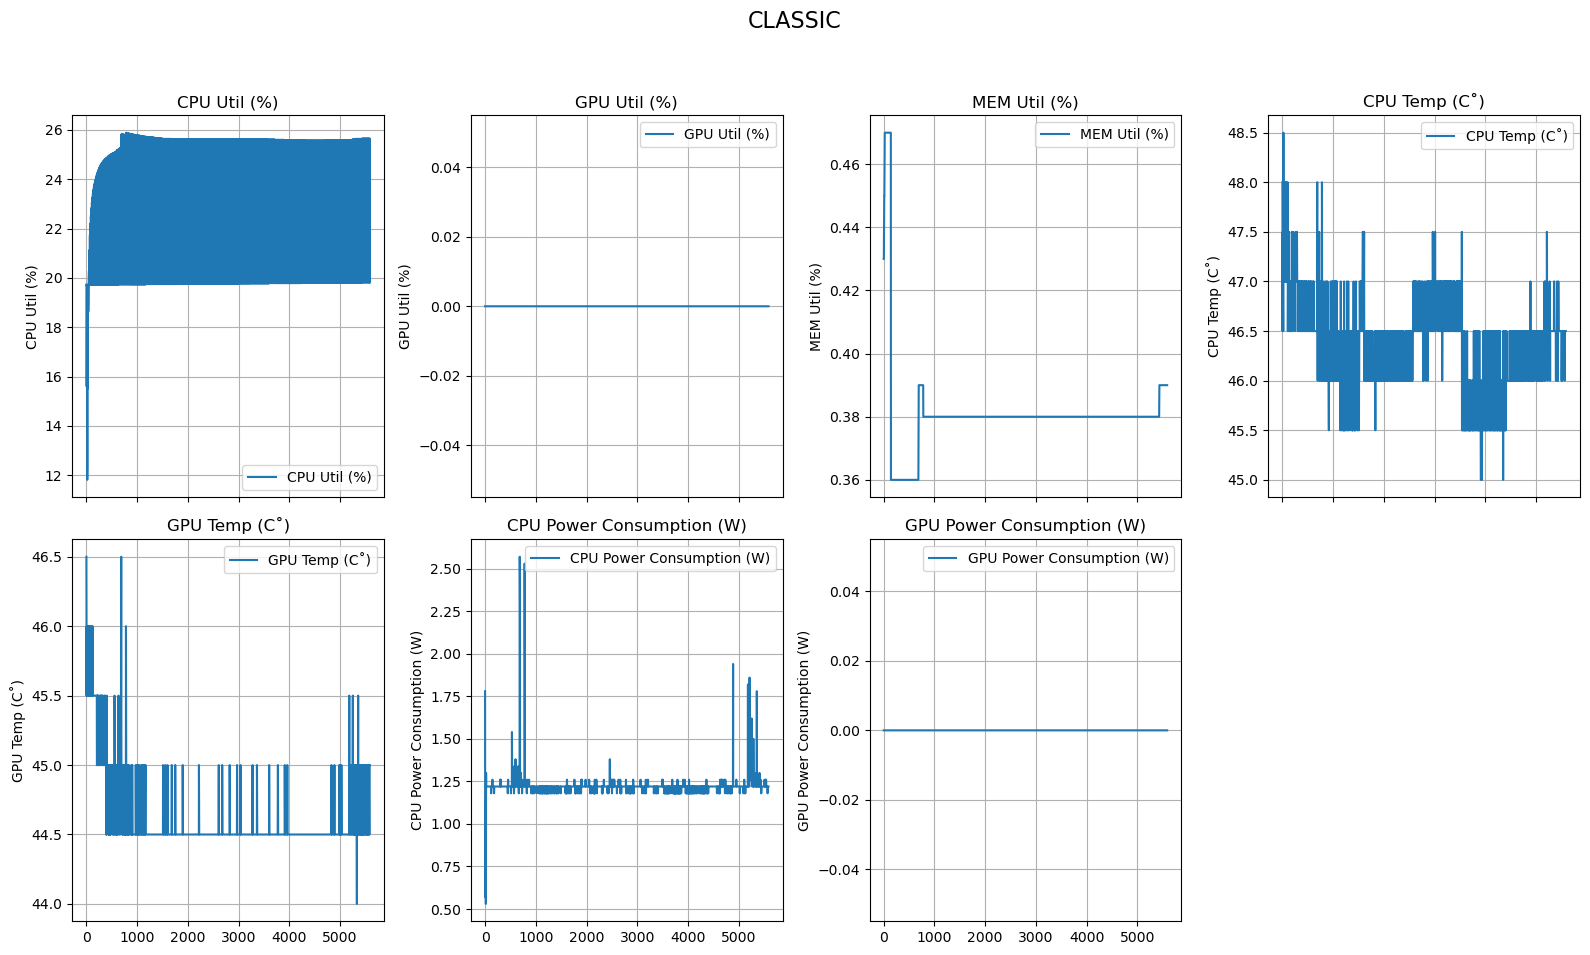

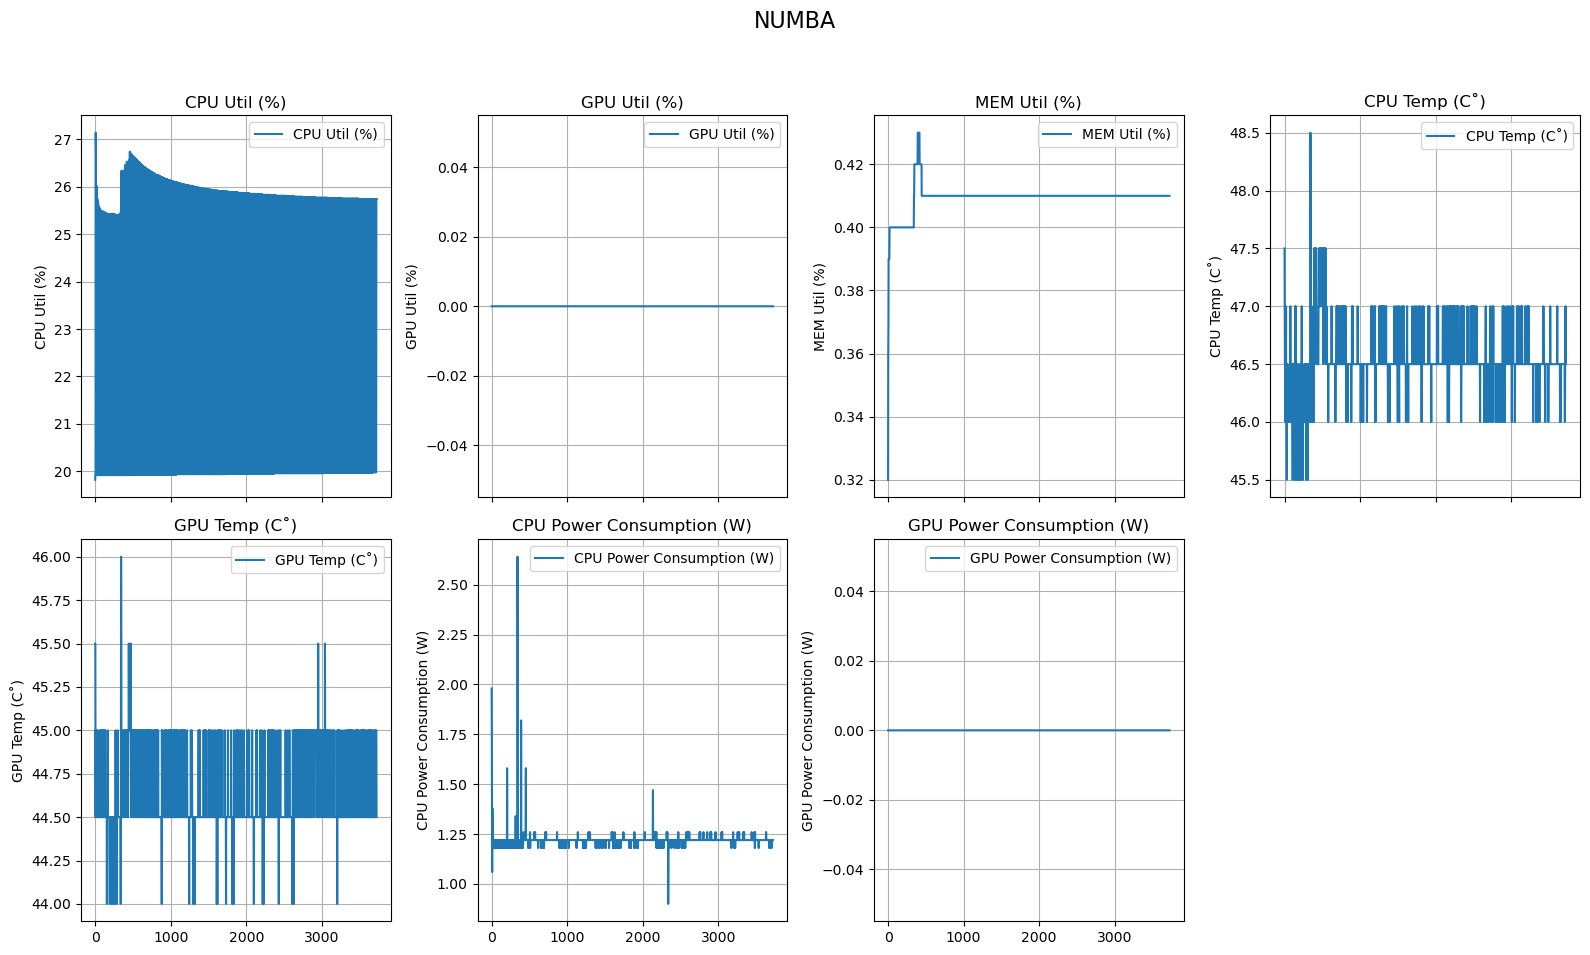

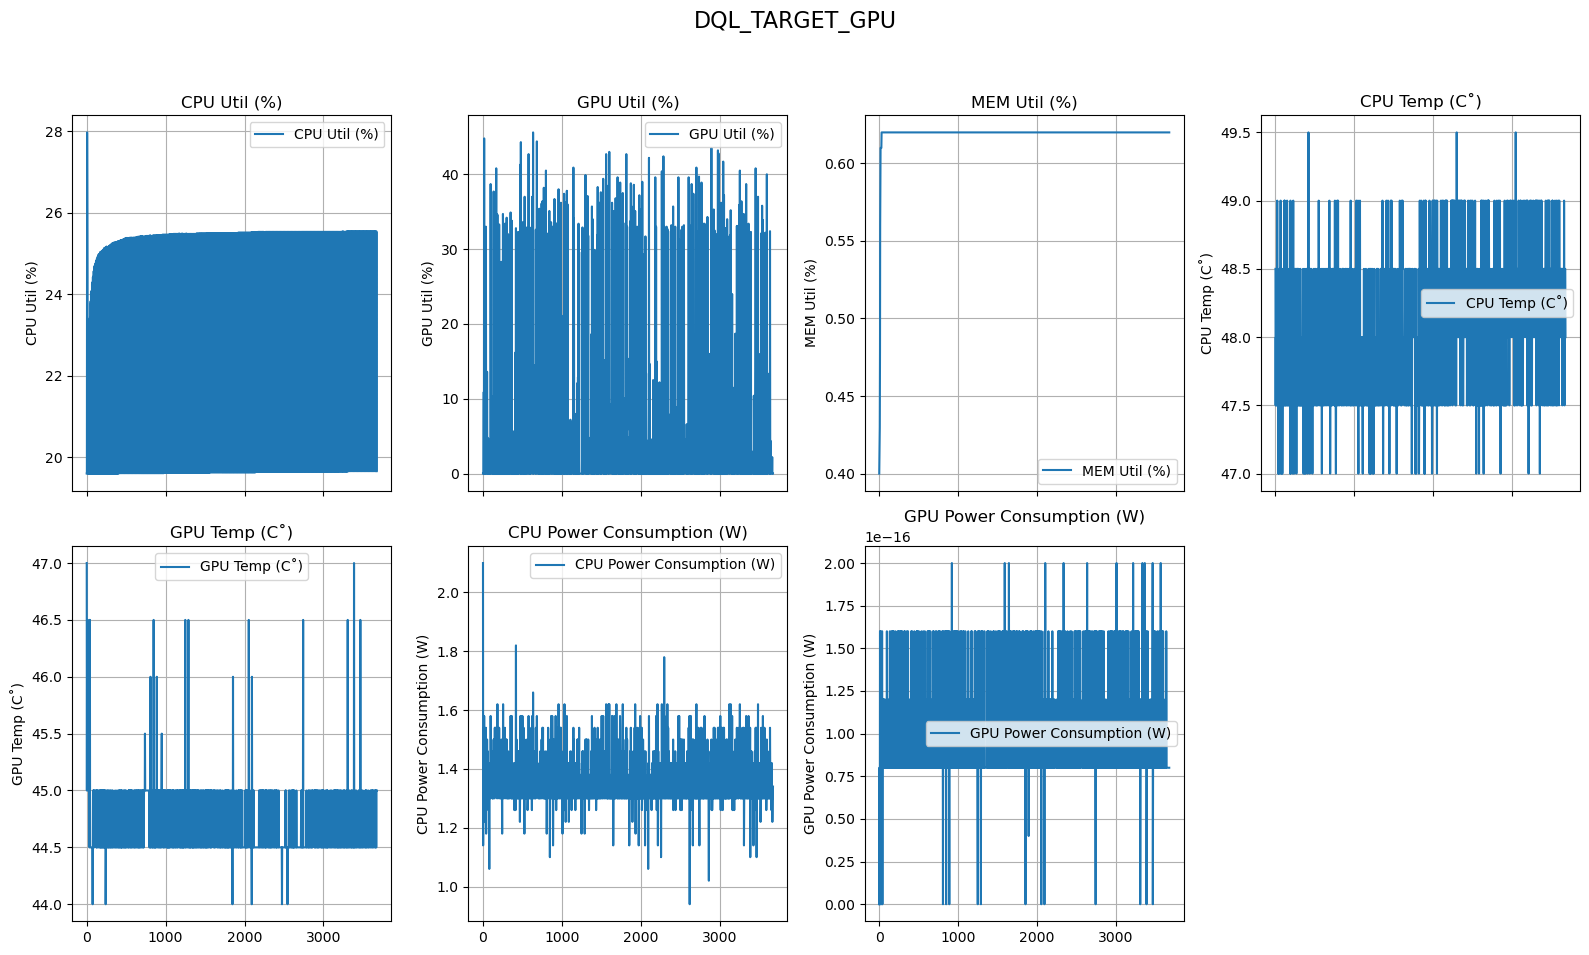

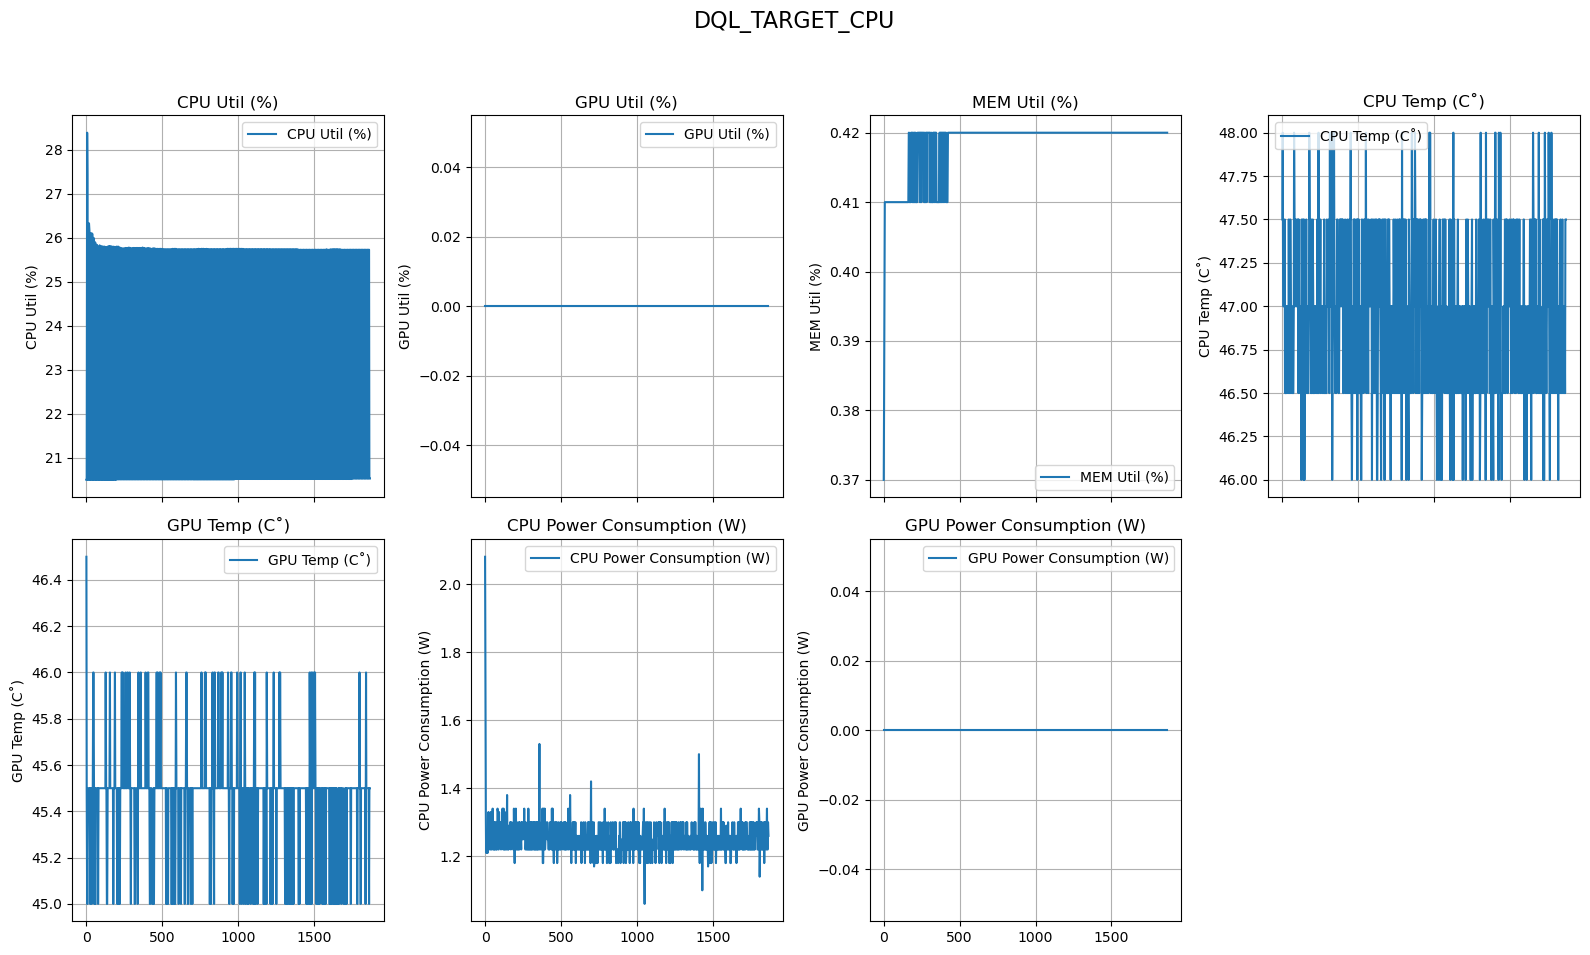

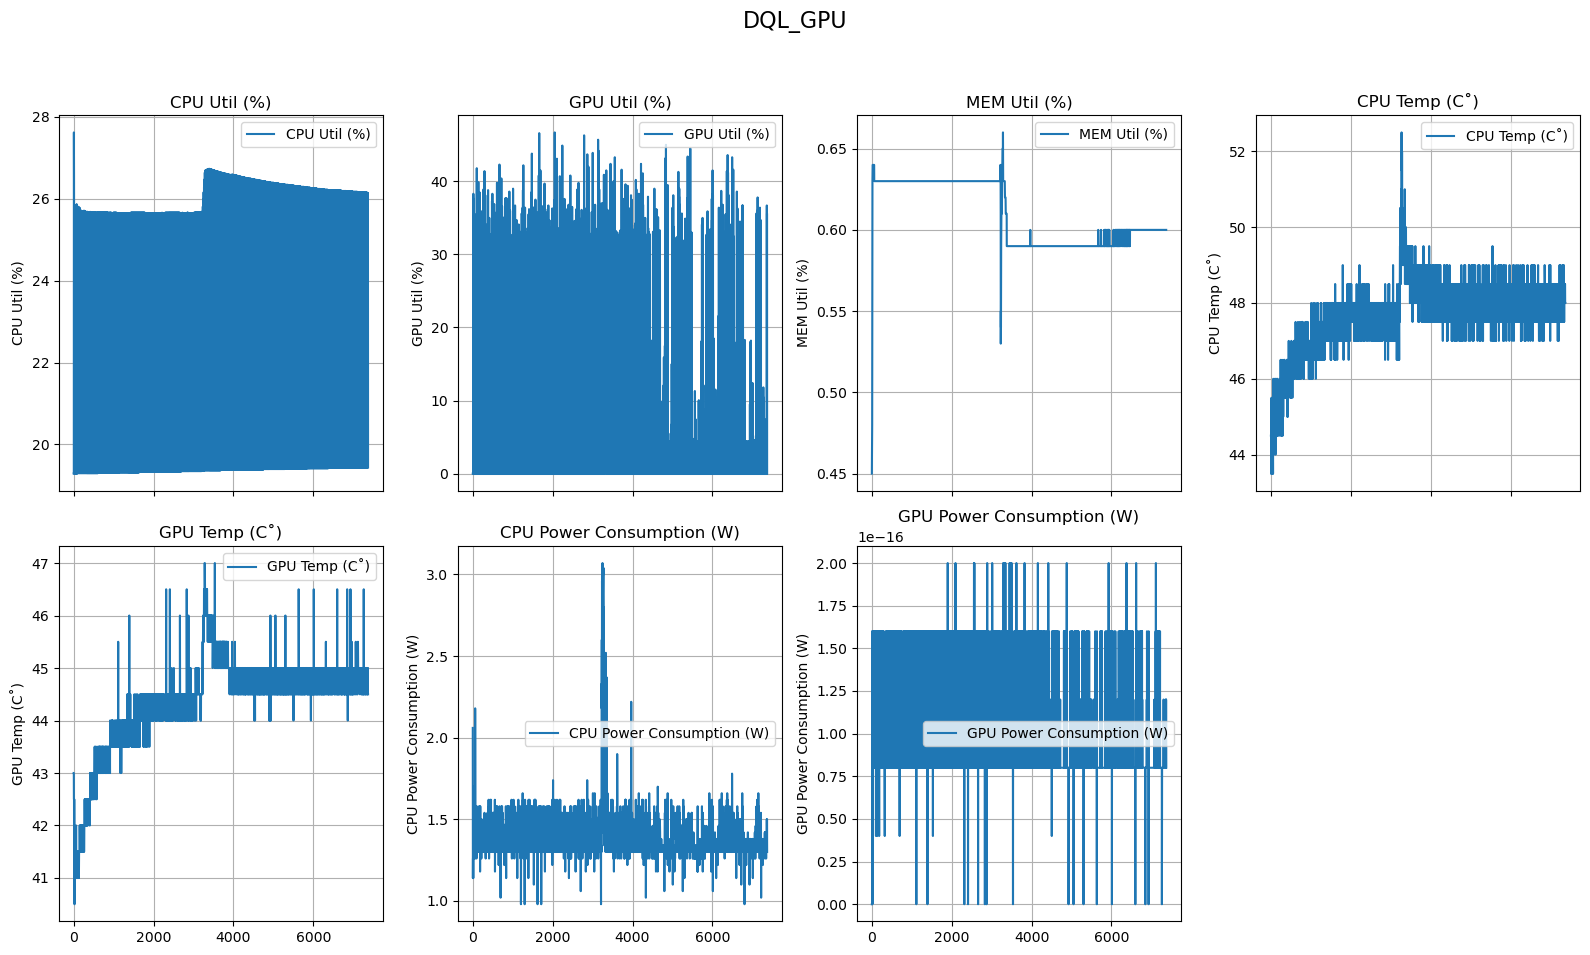

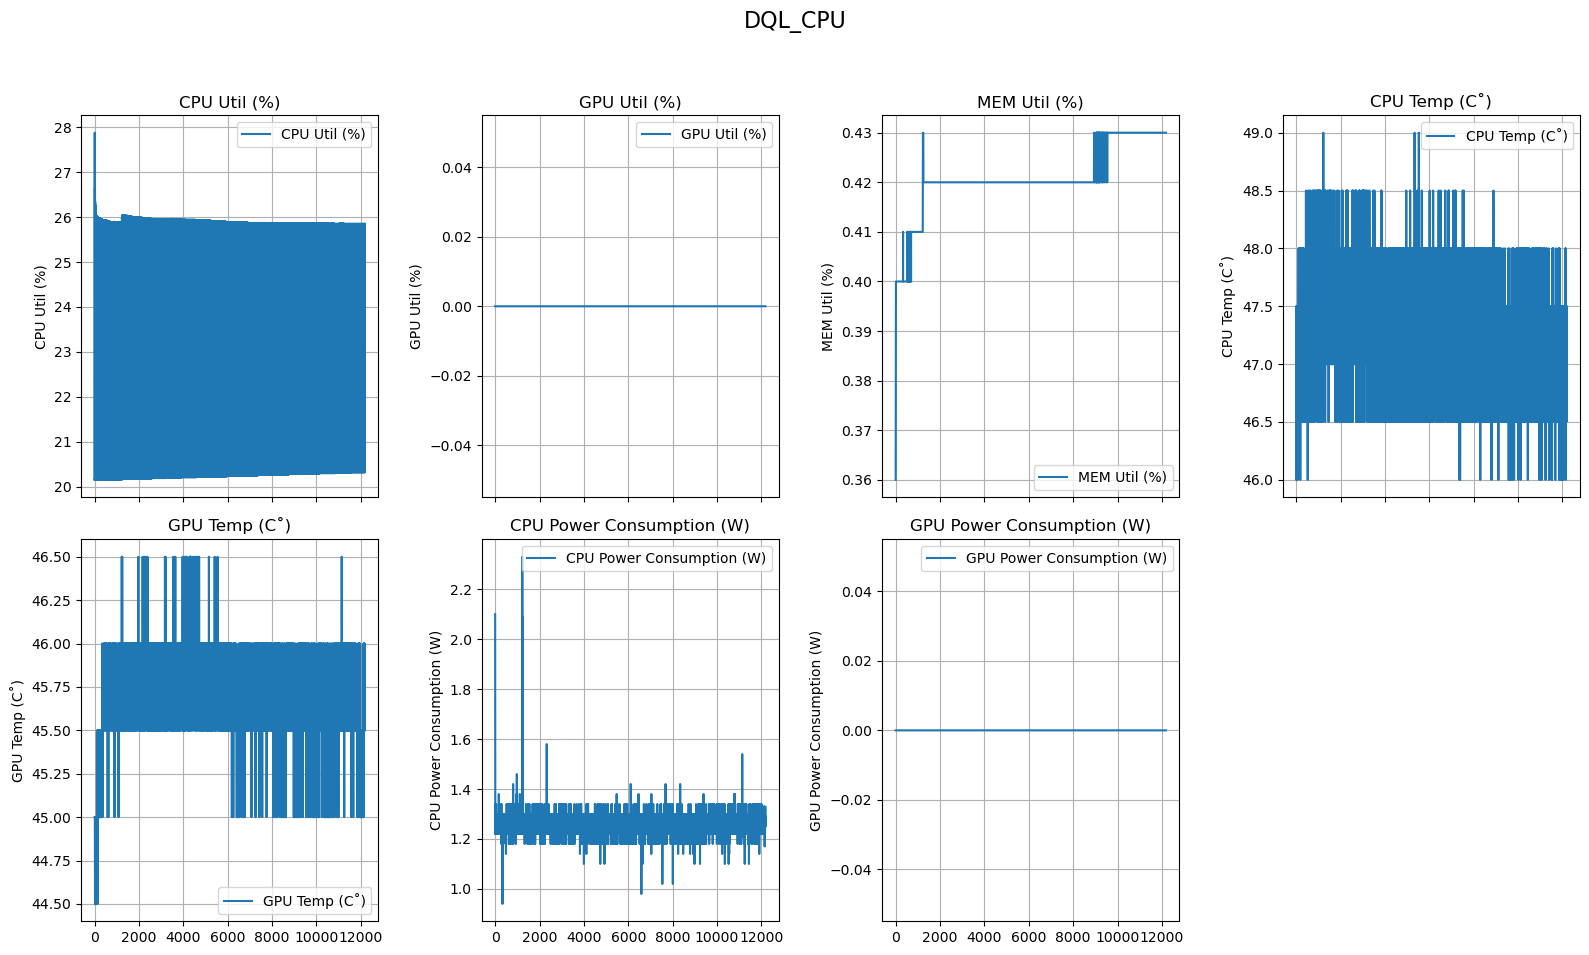

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict

metrics = {
    "CPU Util": "CPU Util (%)",
    "GPU Util": "GPU Util (%)",
    "MEM Util": "MEM Util (%)",
    "CPU Temp": "CPU Temp (C˚)",
    "GPU Temp": "GPU Temp (C˚)",
    "CPU Power Consumption": "CPU Power Consumption (W)",
    "GPU Power Consumption": "GPU Power Consumption (W)",
}

def plot_dataframes(dataframes: Dict[str, pd.DataFrame]):
    for training_type, df in dataframes.items():
        df["TimeDelta"] = pd.to_timedelta(df["Time"])
        min_time = df["TimeDelta"].min()
        df["TimeSinceFirst"] = df["TimeDelta"] - min_time
        df["TimeSinceFirstInSeconds"] = df["TimeSinceFirst"].dt.total_seconds()
        df["GPU Power Consumption"] = df["GPU Power Consumption"] / 100000
        df["CPU Power Consumption"] = df["CPU Power Consumption"]

        n_rows = 2
        n_cols = 4
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 10), sharex=True)
        fig.suptitle(training_type.upper(), fontsize=16)
        
        ax_list = axs.ravel()
        for ax in ax_list[len(metrics.keys()):]:
            ax.set_visible(False)

        for ax, (metric, description) in zip(ax_list, metrics.items()):
            if metric in df.columns:
                ax.plot(
                    df["TimeSinceFirstInSeconds"],
                    df[metric],
                    label=description,
                    linewidth=1.5,
                )
                ax.set_title(description)
                ax.set_ylabel(description)
                ax.grid(True)
                ax.legend()

        plt.xlabel("Time since first measurement (seconds)")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(f"./analysis/jetson/metrics/jetson-{training_type}.png")
        plt.show()

plot_dataframes(jetson_dataframes)

In [52]:
import numpy as np

def average(df: pd.DataFrame, metric: str):
    return np.mean(df[metric])

average_dataframes = {}

for training_type, df in jetson_dataframes.items():
    averages = {}
    
    for metric in metrics.keys():
        averages[f"{metrics[metric]} Avg."] = round(average(df, metric), 2)
    
    average_dataframes[training_type] = pd.DataFrame([averages], index=[training_type.capitalize()])

all_averages_df = pd.concat(average_dataframes.values())

all_averages_df

,CPU Util (%) Avg.,GPU Util (%) Avg.,MEM Util (%) Avg.,CPU Temp (C˚) Avg.,GPU Temp (C˚) Avg.,CPU Power Consumption (W) Avg.,GPU Power Consumption (W) Avg.
Classic,22.59,0.00,0.38,46.34,44.61,1.22,0.0
Numba,22.93,0.00,0.41,46.52,44.64,1.22,0.0
Dql_target_gpu,22.53,6.28,0.62,48.06,44.71,1.36,0.0
Dql_target_cpu,23.13,0.00,0.42,46.92,45.46,1.25,0.0
Dql_gpu,22.71,7.83,0.61,47.68,44.36,1.39,0.0
Dql_cpu,23.07,0.00,0.42,47.24,45.66,1.26,0.0
